# Tinkering Notebook 4: Planning and Learning

In this notebook we look at the methods from Chapter 8 of the textbook. 

This notebook focuses on model based reinforcement learning and integration of learning and planning. Another important theme in the notebook is the exploitation-exploration trade-offs.  We will implement Dyna-Q and Dyna-Q+ and run these on the various maze environments of Example 8.1, 8.2 and 8.3.
    
Note that in this notebook we do not perform averaging over runs,  hence we typically have considerable amount of randomness in our results. This makes it difficult to draw general conclusions about the effect of parameters. You may want to perform averaging over runs after your initial experiments to be able to understand the effect of parameters better. 

# Table of content
* ### [1. Imports](#sec1)
* ### [2. The maze environments](#sec2)
* ### [3. DYNA-Q](#sec3)
 * #### [3.1 Example: Maze](#sec3_1)
* ### [4. DynaQ+](#sec4)
 * #### [4.1 Example: Blocking Maze](#sec4_1)
 * #### [4.2 Example: Shortcut Maze](#sec4_2)


# 1. Imports <a id="sec1">

In [1]:
import gymnasium as gym
import gym_RLcourse
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output # Used to clear the ouput of a Jupyter cell.

# 2. The maze environments <a id="sec2">

In this notebook we will use the environments in Example 8.2 and Example 8.3 in the textbook. These are implemented in `GridWorld-Maze-v0` and you can select between the different mazes by setting `map_name`:

* `map_name = "Figure 8.2"` (default) gives the map in Figure 8.2.
* `map_name = "Figure 8.4a"` gives the left map in Figure 8.4. 
* `map_name = "Figure 8.4b"` gives the right map in Figure 8.4.
* `map_name = "Figure 8.5a"` same as Figure 8.4b. 
* `map_name = "Figure 8.5b"` gives the right map in Figure 8.5.

In [2]:
env = gym.make('GridWorld-Maze-v0', map_name="Figure 8.2", render_mode="human")
state, info = env.reset()
print('State space:', env.observation_space)
print('Action space:', env.action_space)

State space: Discrete(54)
Action space: Discrete(4)


There are 54 states, and 4 actions corresponding to 

In [3]:
WEST = 0
SOUTH = 1
EAST = 2
NORTH = 3

As usual we move around in the environment using `env.step`. 

In [4]:
env.step(NORTH)

(9, 0, False, False, {'prob': 1.0})

**Reward:** The reward is 0 for every action, except when the goal state is reached and a reward of +1 is received. 

# 3. DYNA-Q <a id="sec3">

We now implement Tabular Dyna-Q. 
  
The class `DynaQ` can be called to run either plain Dyna-Q or DynaQ+. 

If `dynaq_plus = True` then Dyna-Q+ is used, otherwise Dyna-Q is used. The Dyna-Q+ version is not fully implemented, but you will complete it later in the notebook. For now we focus on Dyna-Q. 
      
__Task-DQ:__ Assuming `dynaq_plus=False` examine the class below and relate it to DynaQ. Especially look at `learn()`, `update_Q()` and `update_model()` and `plan()` and relate the implementation to Dyna-Q. Note that the comments on top of these functions indicate which lines of the pseudo-code on page 164 the code implements. 

In [6]:
class DynaQ:

    def __init__(self, n_states, n_actions, gamma, alpha, epsilon, n=0, dynaq_plus = False, kappa=1e-3):
        self.n_states = n_states
        self.n_actions = n_actions
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.n = n
        self.dynaq_plus = dynaq_plus
        self.kappa = kappa
        
        self.Q = np.zeros((n_states, n_actions)) # Estimated Q-function
        self.visited = np.zeros((n_states, n_actions)) # 1 if [s,a] has been visited.
        self.model = {}
        
        # Extra information needed for DynaQ-plus
        if dynaq_plus:
            self.time = 0 # Internal counter of time
            self.last_visit = np.zeros((n_states, n_actions)) # Last visit to state/action-pair
            for state in range(n_states):
                # See footnote on page 168
                self.visited[state] = 1
                for action in range(n_actions):
                    self.model[state, action] = state, 0
        
        
    # Tabular DynaQ step (b)
    def act(self, state):
        # Epsilon-greedy policy
        if np.random.rand() > self.epsilon: 
            # Greedy action
            # Break ties randomly
            a_max = np.where(self.Q[state,:] == np.max(self.Q[state,:]))[0]
            action = np.random.choice(a_max) 
        else: 
            # Random action
            action = np.random.choice(self.n_actions)
        
        return action
            
    # Tabular DynaQ step (d) (the Q-learning update)
    def update_Q(self, state, action, reward, state_next):
        Q_next = np.max(self.Q[state_next, :])
        self.Q[state, action] += self.alpha*(reward + self.gamma*Q_next - self.Q[state,action])
        
    # Tabular DynaQ step (e)
    def update_model(self, state, action, reward, state_next):    
        self.visited[state, action] = 1 # We have now seen this state
        self.model[state, action] = state_next, reward
        
        if self.dynaq_plus:
            self.last_visit[state, action] = self.time
            
        
    # Tabular DynaQ step (f)
    def plan(self):
        #All visisted state-action pairs:
        v_states, v_actions = np.nonzero(self.visited)
        
        #Pick out self.n random visisted pairs
        idx = np.random.choice(len(v_states), self.n)
        
        for i in idx:
            state = v_states[i]
            action = v_actions[i]
            [state_next, reward] = self.model[state, action]
            
            if self.dynaq_plus:
                time_passed = self.time - self.last_visit[state, action]
                # TODO modify reward
            
            self.update_Q(state, action, reward, state_next)
    
    # Tabular DynaQ calls (d), (e) and (f)
    def learn(self, state, action, reward, state_next):
        self.update_Q(state, action, reward, state_next)
        self.update_model(state, action, reward, state_next)
        self.plan()    
        
        if self.dynaq_plus:
            self.time += 1

We now introduce `train()` function for ease of experimentation. Note that the function returns the length of episodes in `length_episodes` and rewards over all time steps `rewardA`. 


In [7]:
def train(env, agent, nEpisode):
    episode_length = np.inf*np.ones(nEpisode)
    rewardA = []
    
    for iEpisode in range(nEpisode):
        t = 0  # step index within episode
        state, info = env.reset()
        terminated = False
        truncated = False
        
        while not truncated and not terminated:
            action = agent.act(state)
            state_next, reward, terminated, truncated, info = env.step(action)
            agent.learn(state, action, reward, state_next)
            rewardA.append(reward)
            t += 1
            state = state_next
            
        episode_length[iEpisode] = t
        
    print('Finished')
    return episode_length, rewardA

We now define three functions that can be used to illustrate the behavior of the agent. 

`plot_episode_length` plots the number of step the agent takes before it finish for each episode during the training. This can be compared with Figure 8.2 in the textbook.

`plot_cumulative_rewards` plot the cumulative rewards similar to what is done in Figure 8.4 in the textbook. 

`test_policy` takes an environment `env` (assuming `render_mode="human"`) and lets the `agent` run through one episode.

`plot_policy` gives a visualization of the agents current policy similar to that in Figure 8.3. 

In [8]:
def plot_episode_length(episode_length): # for plots similar to Figure 8.2
    plt.plot(episode_length, label='DYNA-Q')
    plt.xlabel('Episodes')
    plt.ylabel('Steps per Episode')
    plt.legend(loc='best')
    plt.ylim(-5, 800)
    plt.grid(True)
    plt.show()

In [9]:
def plot_cumulative_rewards(rewards1, rewards2): # for plots similar to Figure 8.4
    rewards1_cumulative = np.cumsum(rewards1)
    rewards2_cumulative = np.cumsum(rewards2)
    rewards2_cumulative = np.array(rewards2_cumulative) + rewards1_cumulative[-1]
    rewards_cumulative = np.concatenate([rewards1_cumulative, rewards2_cumulative])
    episode_change = len(rewards1)
    plt.plot(rewards_cumulative)
    plt.plot([episode_change, episode_change], [0, rewards_cumulative[-1]], '--', color='black')
    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative Reward')
    plt.grid(True)
    plt.show()
    
    return rewards_cumulative

In [10]:
def test_policy(env, agent, max_steps=50, render=True):
    state, info = env.reset()
    step = 0
    terminated = False
    truncated = False
    while not terminated and not truncated and step<max_steps:
        action = agent.act(state)
        state, reward, terminated, truncated, info = env.step(action)
        step += 1
        if render:
            clear_output(wait=True)
            # Show some information
            print("Time step:", step)
            print("Action:", action)
            print("Reward:", reward)
            
    if terminated == True:
        print("Finished after", step, " steps.")
    else:
        print("Did not finish within", step, "steps.")

In [19]:
def plot_policy(env, agent):
    directions = {0: ' W ', 1: ' S ', 2: ' E ', 3: ' N '}
    for state in range(env.observation_space.n):
        q = agent.Q[state, :]
        
        if np.ravel(env.desc)[state] == b'W':
            # If it is a "wall"-state
            action = ' # '
        elif np.ravel(env.desc)[state] == b'G':
            # If it is a "goal"-state
            action = ' G '
        elif np.count_nonzero(q == q[0]) == len(q):
            # If all actions have the same value
            action = ' - '
        else:
            action = directions[np.argmax(q)]
            
        print(action, end='')
        position = np.unravel_index(state, [env.nrow, env.ncol])
        if position[1] == env.ncol -1:
            print('')
    print('')
        

## 3.1 Example: Maze <a id="sec3_1">

We create the DynaMaze environment of Example 8.2 and the Dyna-Q agent.

**Task-DM:** What is the length of the episode under an optimal deterministic strategy in the DynaMaze environment?

Let us create a training environment (without rendering) and an agent that uses $n=5$ planing steps.

In [41]:
env_train = gym.make("GridWorld-Maze-v0")
agent = DynaQ(env.observation_space.n, env.action_space.n, gamma=0.95, alpha=0.1, epsilon=0.1, n=5)

We now let the agent train on the environment for 50 episodes. Wait until you see `Finished`.

In [42]:
episode_length, rewardA = train(env_train, agent, nEpisode = 50)

Finished


Let us now plot the total number of steps per episode, similar to Figure 8.2. However, there are two differences compared to Figure 8.2. First, we have only trained the agent once and the results may vary a bit every time you re-train the agent. Figure 8.2 on the other hand show the average when the agent is trained many times. Furthermore, we here plot the number of steps also for the first episode, while Figure 8.2 starts at episode 2.

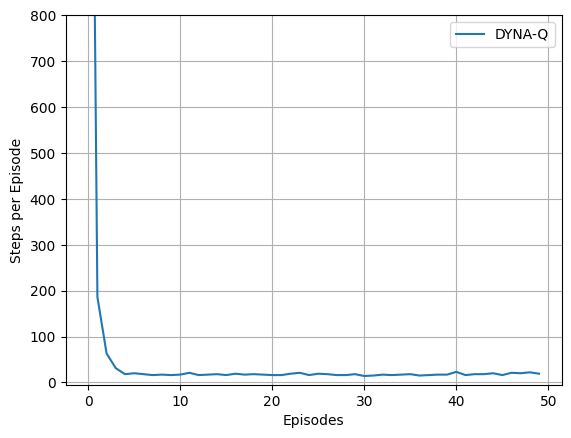

In [43]:
plot_episode_length(episode_length)

If you want to see your trained agent in action, you can use:

In [44]:
env = gym.make('GridWorld-Maze-v0', map_name="Figure 8.2", render_mode="human")
test_policy(env, agent)

Time step: 16
Action: 3
Reward: 1
Finished after 16  steps.


We can also see what greedy policy the agent currently has found:

In [45]:
plot_policy(env_train, agent)

 E  E  E  E  E  S  S  #  G 
 N  N  #  S  E  S  S  #  N 
 N  S  #  S  E  S  S  #  N 
 E  S  #  E  E  E  E  E  N 
 E  E  E  E  N  #  N  N  N 
 N  E  N  N  N  E  N  N  N 



**Task-DQ1**: Vary the number of planning steps `n` and plot steps per episode again. Repeat your experiments with the same parameters multiple times. Compare your results to Figure 8.2.

Finished


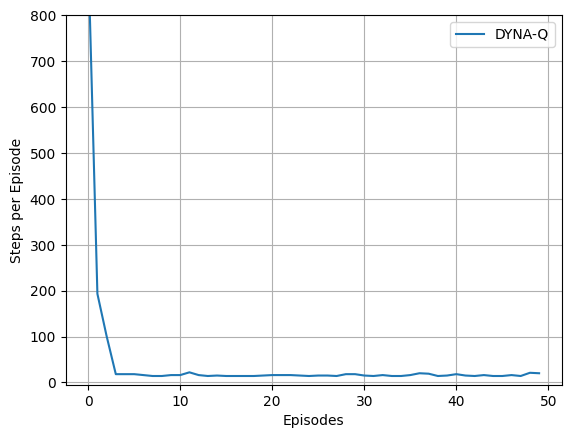

In [68]:
agent = DynaQ(env.observation_space.n, env.action_space.n, gamma=0.95, alpha=0.1, epsilon=0.1, n=5)
episode_length, rewardA = train(env_train, agent, nEpisode = 50)
plot_episode_length(episode_length)

**Task-DQ2:** Look at the evolution of the policy during training. You can do this by running one episode at a time, and then plot the policy. Vary the number of planning steps `n` (remember that with `n=0` you get $Q$-learning). How do your results compare to the discussion in Example 8.1 of the textbook?

In [59]:
agent = DynaQ(env.observation_space.n, env.action_space.n, gamma=0.95, alpha=0.1, epsilon=0.1, n=5)

In [56]:
episode_length, rewardA = train(env_train, agent, nEpisode = 1)
plot_policy(env_train, agent)

Finished
 E  E  E  E  S  E  S  #  G 
 -  N  #  E  S  S  S  #  N 
 -  N  #  S  E  S  S  #  N 
 -  S  #  E  E  E  E  E  N 
 -  S  E  E  N  #  E  E  N 
 -  E  N  E  E  E  N  E  N 



To train for one more episode, re-run the second code block (if you re-run the first code block then your agent re-starts from scratch).

**Task-DQ3**: Recall your answer to Task-DM (the optimal number of steps). Even after obtaining the optimal policy, the agent may use a higher number of steps to reach the goal. Why? If you have trained the agent long enough to have an optimal policy, you can test it a few times with the code below. Does it use the same number of steps every time?

In [74]:
env = gym.make('GridWorld-Maze-v0', map_name="Figure 8.2", render_mode="human")
test_policy(env, agent)

Time step: 17
Action: 3
Reward: 1
Finished after 17  steps.


# 4. DynaQ+ <a id="sec4">

We now consider DynaQ+ (page 168). Note that this is a variant of Dyna-Q and no separate algorithm is provided on the page on page 168. You need to read the text and the footnote to understand how Dyna-Q+ is different from Dyna-Q. 

__Task-DQ+ 1:__ In `DynaQ()` class above, $\color{blue}{\text{the reward modification is not implemented for  DynaQ+}}$. In particular, we have not implemented the following statement from the book: "... if the modeled reward for a transition is $r$, and the transition has not been tried in $\tau$ time steps, then planning updates are done as if that transition produced a reward of $r + \kappa \sqrt{\tau}$, for some small $\kappa$". Complete the implementation. The location of the code you need to fill in can be found by searching for the "TODO" in this file. 

__Task-DQ+ 2:__ Relate the idea behind Dyna-Q+ to the exploitation-exploration trade-off.

## 4.1 Example: Blocking Maze <a id="sec4_1">

We now focus on Example 8.2. Here we will switch between two different environments. When the agent is training it will use the `map_name="Figure 8.4a` for 20 episode:

In [75]:
env = gym.make('GridWorld-Maze-v0', map_name="Figure 8.4a", render_mode="human")
state, info = env.reset()
print('State space:', env.observation_space)
print('Action space:', env.action_space)

State space: Discrete(54)
Action space: Discrete(4)


After this the environment is changed to `map_name="Figure 8.4b"`, and the agent continues the training. 

In [120]:
env = gym.make('GridWorld-Maze-v0', map_name="Figure 8.4b", render_mode="human")
state, info = env.reset()
print('State space:', env.observation_space)
print('Action space:', env.action_space)

State space: Discrete(54)
Action space: Discrete(4)


To perform the training, you can use the code below.

In [121]:
agent = DynaQ(env.observation_space.n, env.action_space.n, gamma=0.95, alpha=0.5, epsilon=0.1, n=20, dynaq_plus=True, kappa=0.99)
env_train = gym.make('GridWorld-Maze-v0', map_name="Figure 8.4a")
steps_episodes1, rewards1 = train(env_train, agent, nEpisode=20)
env_train = gym.make('GridWorld-Maze-v0', map_name="Figure 8.4b")
steps_episodes2, rewards2 = train(env_train, agent, nEpisode=20)
print('Both finished')

Finished
Finished
Both finished


We now plot the cumulative reward, similar to Figure 8.5 in the textbook (note however that we switch environment after 20 episodes instead of after 1000 time steps, and that Figure 8.5 shows the average over many runs). 

The dashed line shows when the environment switched. 

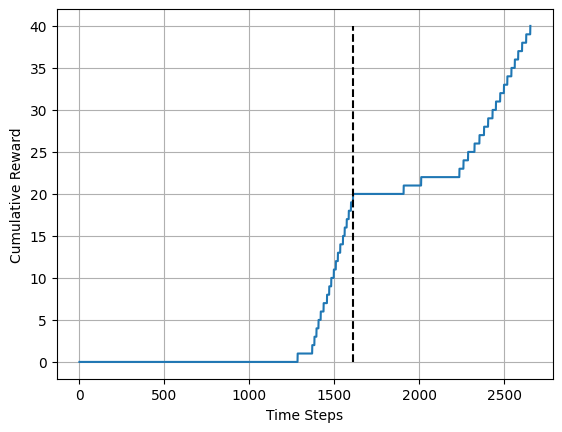

In [122]:
plot_cumulative_rewards(rewards1, rewards2);

You will probably see that after the environment switch, the line goes flat for some time. This is because the agent first learned to use the short path but this is now blocked. Hence, in the first episode after the environment switch, the agent has to figure out a new way to the goal and thus the first episode after the switch will take longer time. 

It can be of interest to see how many time steps the agent took in the first and last episode before and after the switch. 

In [79]:
print("First episode BEFORE switch:", steps_episodes1[0], "steps.")
print("Last episode BEFORE switch:", steps_episodes1[-1], "steps.")
print("First episode AFTER switch:", steps_episodes2[0], "steps.")
print("Last episode AFTER switch:", steps_episodes2[-1], "steps.")

First episode BEFORE switch: 122.0 steps.
Last episode BEFORE switch: 12.0 steps.
First episode AFTER switch: 724.0 steps.
Last episode AFTER switch: 18.0 steps.


**Task-BM1:** If you run the experiment a few times, you will see that the first episode is often shorter than the first episode after the switch. Why is that?

**Task-BM2:** Try the experiments a few times with DynaQ instead of DynaQ+ (set `dynaq_pluse = False`). Do you see a difference in the number of steps for the first episode after the change? 

**Task-BM3:** Experiment with different values of $\kappa$ in DynaQ+. Try extremely large and small values. How does $\kappa$ change the results? Why?

**Task-BM4:** Below are two code blocks. In the first block the agent is trained on Figure 8.4a, and then the policy learned is used on Figure 8.4b. In the second block the agent continue training, but now on Figure 8.4b. It trains for one episode, and then the policy used on Figure 8.4b. You can re-run the second code block several times the let the agent train more on the new environment and see how the policy evolves. Try different values of $\kappa$ and $n$.

In [95]:
agent = DynaQ(env.observation_space.n, env.action_space.n, gamma=0.95, alpha=0.5, epsilon=0.1, n=20, dynaq_plus=False, kappa=0.001)
env_train = gym.make('GridWorld-Maze-v0', map_name="Figure 8.4a")
steps_episodes1, rewards1 = train(env_train, agent, nEpisode=20)

# Run the last policy from before the switch on the environment after the switch
env = gym.make('GridWorld-Maze-v0', map_name="Figure 8.4b", render_mode="human")
test_policy(env, agent, max_steps=30)

Time step: 30
Action: 3
Reward: 0
Did not finish within 30 steps.


In [99]:
env_train = gym.make('GridWorld-Maze-v0', map_name="Figure 8.4b")
steps_episodes2, rewards2 = train(env_train, agent, nEpisode=1)

# Run the policy when it has trained on the new environment for one episode
env = gym.make('GridWorld-Maze-v0', map_name="Figure 8.4b", render_mode="human")
test_policy(env, agent, max_steps=30)


Time step: 18
Action: 3
Reward: 1
Finished after 18  steps.


## 4.2 Example: Shortcut Maze <a id="sec4_2">

We now consider Example 8.3. Here the agent trains on Figure 8.5a for 100 episodes:

In [153]:
env = gym.make('GridWorld-Maze-v0', map_name="Figure 8.5a", render_mode="human")
state, info = env.reset()
print('State space:', env.observation_space)
print('Action space:', env.action_space)

State space: Discrete(54)
Action space: Discrete(4)


After this a shortcut opens up and Figure 8.5b is used instead for 100 episodes:

In [154]:
env = gym.make('GridWorld-Maze-v0', map_name="Figure 8.5b", render_mode="human")
state, info = env.reset()
print('State space:', env.observation_space)
print('Action space:', env.action_space)

State space: Discrete(54)
Action space: Discrete(4)


The training can be done with the following code:

In [155]:
agent = DynaQ(env.observation_space.n, env.action_space.n, gamma=0.95, alpha=0.5, epsilon=0.1, n=20, dynaq_plus=False, kappa=0.01)
env_train = gym.make('GridWorld-Maze-v0', map_name="Figure 8.5a")
steps_episodes1, rewards1 = train(env_train, agent, nEpisode=100)

# Uncomment the following if you want to see the agent in action with the policy
# learnet from Figure 8.5a.
#env = gym.make('GridWorld-Maze-v0', map_name="Figure 8.5b", render_mode="human")
#test_policy(env, agent)

env_train = gym.make('GridWorld-Maze-v0', map_name="Figure 8.5b")
steps_episodes2, rewards2 = train(env_train, agent, nEpisode=150)

# Uncomment the following if you want to see the agent in action with the final policy.
#env = gym.make('GridWorld-Maze-v0', map_name="Figure 8.5b", render_mode="human")
#test_policy(env, agent)

print('Both finished')

Finished
Finished
Both finished


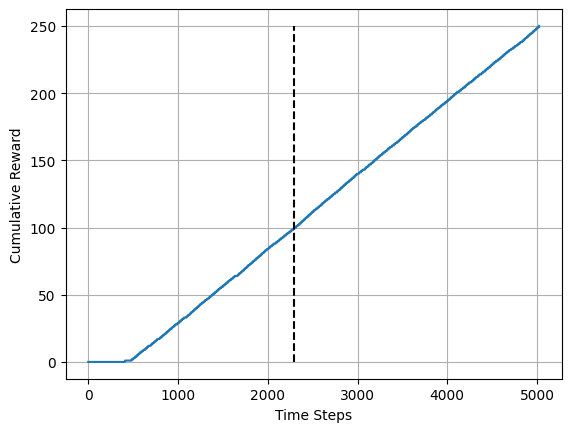

In [156]:
plot_cumulative_rewards(rewards1, rewards2);

In [144]:
print("First episode BEFORE switch:", steps_episodes1[0], "steps.")
print("Last episode BEFORE switch:", steps_episodes1[-1], "steps.")
print("First episode AFTER switch:", steps_episodes2[0], "steps.")
print("Last episode AFTER switch:", steps_episodes2[-1], "steps.")

First episode BEFORE switch: 541.0 steps.
Last episode BEFORE switch: 19.0 steps.
First episode AFTER switch: 26.0 steps.
Last episode AFTER switch: 21.0 steps.


**Task-SM1:** Run the experiment above a few times with both DynaQ and DynaQ+ with different values of $n$. In the figure of cumulative reward, you will see that the agent learns to use the short-cut if the slope of the curve changes. If you want the see the policy just after the switch and the final policy in action uncomment the code for this in the code block above. 

**Task-SM2:** Try to vary $\kappa$ in DynaQ. Try very large and very small values. Explain your results. (Note that the training is stochastic, so re-run your experiments a few time for each $\kappa$)

**Task-SM3:** The key behind DynaQ+ is that it encourage exploration of states that has not been seen for some time. Another way to get more exploration is of course to increase $\varepsilon$. Can you make the agent detect the change in the environment faster by increasing $\varepsilon$? What are potential drawbacks?

**Task-SM4:** (\*) Work on Exercise 8.4.